# <a href="https://girafe.ai/" target="_blank" rel="noopener noreferrer"><img src="https://raw.githubusercontent.com/girafe-ai/ml-course/7096a5df4cada5ee651be1e3215c2f7fb8a7e0bf/logo_margin.svg" alt="girafe-ai logo" width="150px" align="left"></a> [ml-basic course](https://github.com/girafe-ai/ml-course) <a class="tocSkip">

# Lab assignment №1, part 2
## Gradient boosting on temporal data and feature importances

Today we will work with Gradient Boosting library. It is one of the most popular models these days that shows both great quality and performance.

Choises for library are:

* [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. Handful and fast.
* [Catboost](https://github.com/catboost/catboost) by Yandex. Tuned to deal well with categorical features.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.

**Dataset**

By default we will work with widely known [Human Actividy Recognition (HAR) dataset](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones). Data is available at UCI repository.

There are available both raw and preprocessed datasets. This time we will use the preprocessed one.
Some simple preprocessing is done for you.

If you want more interpretable data, you can take [Wine quality dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) (see details below).

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to.

_Despite the main language of this notebook is English, feel free to write your thoughts in Russian._

## Part 0. Downloading and preprocessing

The preprocessing is done for you. Let's take a look at the data:

In [14]:
# Download and unpack dataset from UCI
#!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
#!unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/train/X_train.txt" "UCI HAR Dataset/train/y_train.txt" \
#"UCI HAR Dataset/test/X_test.txt" "UCI HAR Dataset/test/y_test.txt" "UCI HAR Dataset/activity_labels.txt"

**I will stick to this dataset**

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
X_train = np.genfromtxt("UCI HAR Dataset/train/X_train.txt")
y_train = np.genfromtxt("UCI HAR Dataset/train/y_train.txt")
print(f"Train set: {X_train.shape}, {y_train.shape}")

X_test = np.genfromtxt("UCI HAR Dataset/test/X_test.txt")
y_test = np.genfromtxt("UCI HAR Dataset/test/y_test.txt")
print(f"Test set: {X_test.shape}, {y_test.shape}")

n_features = X_train.shape[1]

Train set: (7352, 561), (7352,)
Test set: (2947, 561), (2947,)


In [3]:
activity_labels = {}
with open("UCI HAR Dataset/activity_labels.txt", "r") as file:
    for line in file:
        label, name = line.strip().split(" ")
        activity_labels[int(label)] = name

activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

Let's normalize data

In [4]:
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean) / data_std
X_test = (X_test - data_mean) / data_std

The dataset has some duplicating features. Let's remove them

In [5]:
# fmt: off
duplicating_columns = (
    205, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 231, 244, 257, 507, 520, 533, 546,
)
# fmt: on

duplicating_mask = np.isin(range(n_features), duplicating_columns)

In [6]:
X_train_unique = X_train[:, ~duplicating_mask]
X_test_unique = X_test[:, ~duplicating_mask]

X_train_unique.shape, X_test_unique.shape

((7352, 540), (2947, 540))

PCA could be useful in this case. E.g.

In [7]:
from sklearn.decomposition import PCA

In [8]:
pca = PCA(0.99)

X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

X_train_pca.shape, X_test_pca.shape

((7352, 179), (2947, 179))

Text(0, 0.5, 'Principal component 2')

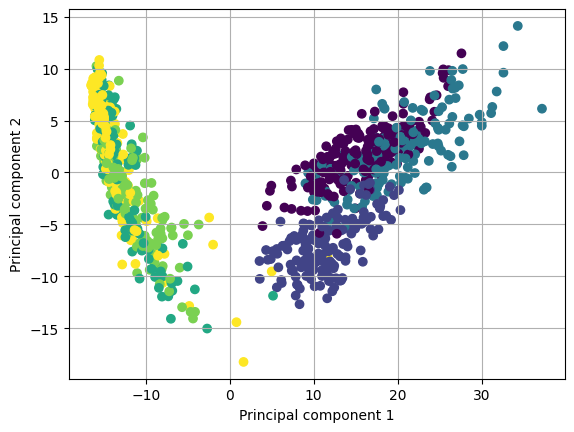

In [9]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

Text(0, 0.5, 'Principal component 5')

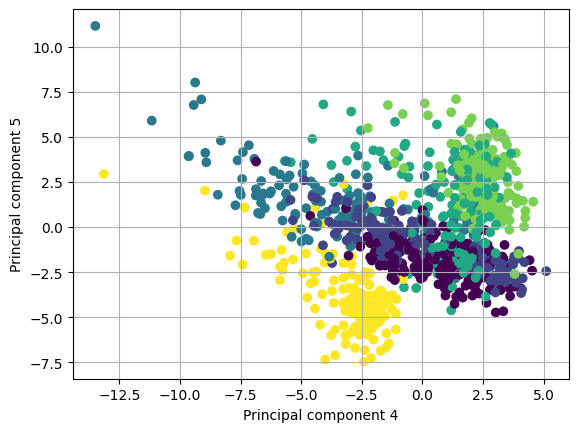

In [10]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 4")
plt.ylabel("Principal component 5")

### Alternative dataset: Wine quality

Please, take this dataset if you are sure you can preprocess it yourself and ready to work with it's features and results, so it is done on your risk.

However you will have interpretable features which can be analysed with shap in last part

In [11]:
#!pip install ucimlrepo

In [12]:
import ucimlrepo as uci

In [13]:
dataset = uci.fetch_ucirepo(id=186)

print(dataset.metadata.name, '\n')
print(dataset.metadata.abstract, '\n')
print(dataset.metadata.additional_info.summary, '\n')

Wine Quality 

Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/). 

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].  Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks.  The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to t

## Part 1. Fit the model.

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to approximate them by yourself.

In this part just check some (3-5) sets of hyperparameters by hand.

In [14]:
# YOUR CODE HERE

# Example: https://rpubs.com/burakh/har_xgb

In [15]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [16]:
y_train -= 1
y_test -= 1

**We don't really care about feature normalization or PCA since our base estimator is a tree. So, I won't use `X_train_pca`**

In [19]:
features_train, features_val, target_train, target_val = train_test_split(X_train_unique, y_train, test_size=0.2, random_state=42)
features_train.shape, features_val.shape

((5881, 540), (1471, 540))

In [56]:
params_tmp = {
    'feature_pre_filter': False,
}

d_train = lgb.Dataset(features_train, target_train, params=params_tmp)
d_val = lgb.Dataset(features_val, target_val, params=params_tmp)
d_test = lgb.Dataset(X_test_unique, y_test, params=params_tmp)

**Tried some hyperparameters here by hand (I really did, trust me)**

In [57]:
params = {
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    'num_class': 6,
    "num_leaves": 10,
    "verbose": -1,
    "min_data_in_leaf": 10,
    'n_estimators': 40,
    'max_depth': 10,
    'feature_pre_filter': False,
}

model = lgb.train(params, d_train, valid_sets=[d_val])

C:\Users\msi\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [58]:
target_pred_train = np.argmax(model.predict(features_train), axis=-1)
target_pred_val = np.argmax(model.predict(features_val), axis=-1)
target_pred_test = np.argmax(model.predict(X_test_unique), axis=-1)

acc_train = accuracy_score(target_train, target_pred_train)
acc_val = accuracy_score(target_val, target_pred_val)
acc_test = accuracy_score(y_test, target_pred_test)

In [59]:
print(f'Train accuracy: {acc_train:0.4f}')
print(f'Validation accuracy: {acc_val:0.4f}')
print(f'Test accuracy: {acc_test:0.4f}')

Train accuracy: 0.9946
Validation accuracy: 0.9837
Test accuracy: 0.9203


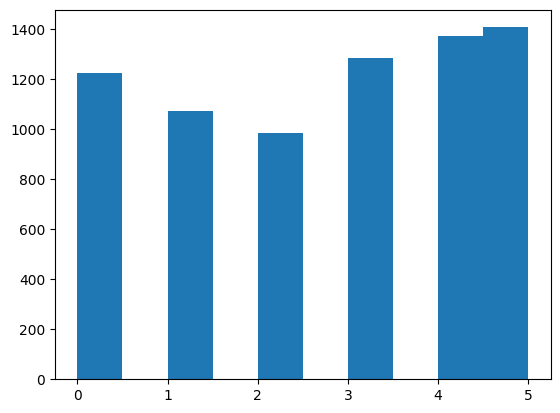

In [60]:
a, b, c = plt.hist(y_train)

Proportions of classes in dataset are *relatively* close to 1, so `accuracy` is *OK* metric for analisys (It's also a required one in the task)

## Part 2. Use hyper parameter tuning system

Use [optuna](https://optuna.org/), [hyperopt](http://hyperopt.github.io/hyperopt/) or any other zero order optimizer to find optimal hyper param set.

In [66]:
# YOUR CODE HERE
import optuna

In [67]:
def objective(trial: optuna.Trial) -> float:
	num_leaves = trial.suggest_int("num_leaves", 2, 10)
	max_depth = trial.suggest_int('max_depth', -1, 7) # there is no need to use deep trees
	n_estimators = trial.suggest_int('n_estimators', 5, 75, step=10)
	min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 100, step=2)
	l1 = trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True)
	l2 = trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True)

	lgb_params = {
		'is_balance': True,
		"learning_rate": 0.05,
		"boosting_type": "gbdt",
		"objective": "multiclass",
		"metric": "multi_logloss",
		"num_leaves": num_leaves,
		"verbose": -1,
		"min_data_in_leaf": min_data_in_leaf,
		'n_estimators': n_estimators,
		'num_class': 6,
		'max_depth': max_depth,
		'lambda_l1': l1,
    	'lambda_l2': l2,
		'feature_pre_filter': False,
	}

	model = lgb.train(params=lgb_params, train_set=d_train, valid_sets=[d_val])

	#target_pred_train = model.predict(features_train)
	#target_pred_val = model.predict(features_val)
	target_pred_val = np.argmax(model.predict(features_val), axis=-1)

	#acc_train = accuracy_score(target_train, target_pred_train)
	acc_val = accuracy_score(target_val, target_pred_val)

	# wanna have good accuracy on val set
	return acc_val

In [68]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2024-11-17 21:59:12,671] A new study created in memory with name: no-name-d67aff1a-8e19-49bf-a9ff-5e1147a2d42d
C:\Users\msi\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 99].
  warnings.warn(
C:\Users\msi\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2024-11-17 21:59:13,906] Trial 0 finished with value: 0.9517335146159075 and parameters: {'num_leaves': 3, 'max_depth': -1, 'n_estimators': 55, 'min_data_in_leaf': 35, 'lambda_l1': 0.017727101455477626, 'lambda_l2': 2.193175706636286e-06}. Best is trial 0 with value: 0.9517335146159075.
C:\Users\msi\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:708: UserWarning: The dis

In [69]:
study.best_params

{'num_leaves': 10,
 'max_depth': -1,
 'n_estimators': 75,
 'min_data_in_leaf': 59,
 'lambda_l1': 0.01052100962878733,
 'lambda_l2': 0.0007878107706317549}

In [70]:
best_lgb_params = {
		'is_balance': True,
		"learning_rate": 0.05,
		"boosting_type": "gbdt",
		"objective": "multiclass",
		"metric": "multi_logloss",
		"num_leaves": None,
		"verbose": -1,
		"min_data_in_leaf": None,
		'n_estimators': None,
		'num_class': 6,
		'max_depth': None,
		'lambda_l1': None,
    	'lambda_l2': None,
		'feature_pre_filter': False,
	}

for key in best_lgb_params:
    if best_lgb_params[key] == None:
        best_lgb_params[key] = study.best_params[key]

best_lgb_params

{'is_balance': True,
 'learning_rate': 0.05,
 'boosting_type': 'gbdt',
 'objective': 'multiclass',
 'metric': 'multi_logloss',
 'num_leaves': 10,
 'verbose': -1,
 'min_data_in_leaf': 59,
 'n_estimators': 75,
 'num_class': 6,
 'max_depth': -1,
 'lambda_l1': 0.01052100962878733,
 'lambda_l2': 0.0007878107706317549,
 'feature_pre_filter': False}

In [73]:
model_opt = lgb.train(best_lgb_params, train_set=d_train, valid_sets=[d_val])

target_pred_train = np.argmax(model_opt.predict(features_train), axis=-1)
target_pred_val = np.argmax(model_opt.predict(features_val), axis=-1)

acc_train = accuracy_score(target_train, target_pred_train)
acc_val = accuracy_score(target_val, target_pred_val)

print(f'\nTrain accuracy of best model: {acc_train:0.4f}')
print(f'Validation accuracy of best model: {acc_val:0.4f}')

C:\Users\msi\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Train accuracy of best model: 0.9997
Validation accuracy of best model: 0.9912


In [75]:
target_pred_test = np.argmax(model_opt.predict(X_test_unique), axis=-1)
acc_test = accuracy_score(target_pred_test, y_test)
print(f'Test accuracy of best model: {acc_test:0.4f}')
assert acc_test > 0.9, 'Test accuracy is higher than required!'

Test accuracy of best model: 0.9379


### Conclusion

Please, write down your thoughts on the experiment results:

(I will repeat some points here also)

1) It is not necessary to use `normalization` and `PCA` here, since we are working with trees

2) Proportions of classes in dataset are *relatively* close to 1, so `accuracy` is *OK* metric for analisys (It's also a required one in the task)

3) No weird stuff like `data leakage` from `train` to `val` happening (there is just no place for it), so our pipeline is applicable

4) We achieved good `accuracy` on test set

## Part 3. Interpret the model predictions

Please use [shap](https://github.com/slundberg/shap) to build some plots and try to interpret them.

In [113]:
import shap  # noqa: F401

# YOUR CODE HERE

In [115]:
explainer = shap.TreeExplainer(model_opt)
shap_values = explainer(X_train_unique)
shap_values.shape

(7352, 540, 6)

In [116]:
class_idx = 1
row_idx = 0
expected_value = explainer.expected_value[class_idx]
shap_value = shap_values[:, :, class_idx].values[row_idx]

In [118]:
shap.force_plot(
    base_value=expected_value,
    shap_values=shap_value,
    features=X_train_unique[row_idx, :],
    link="logit",
)

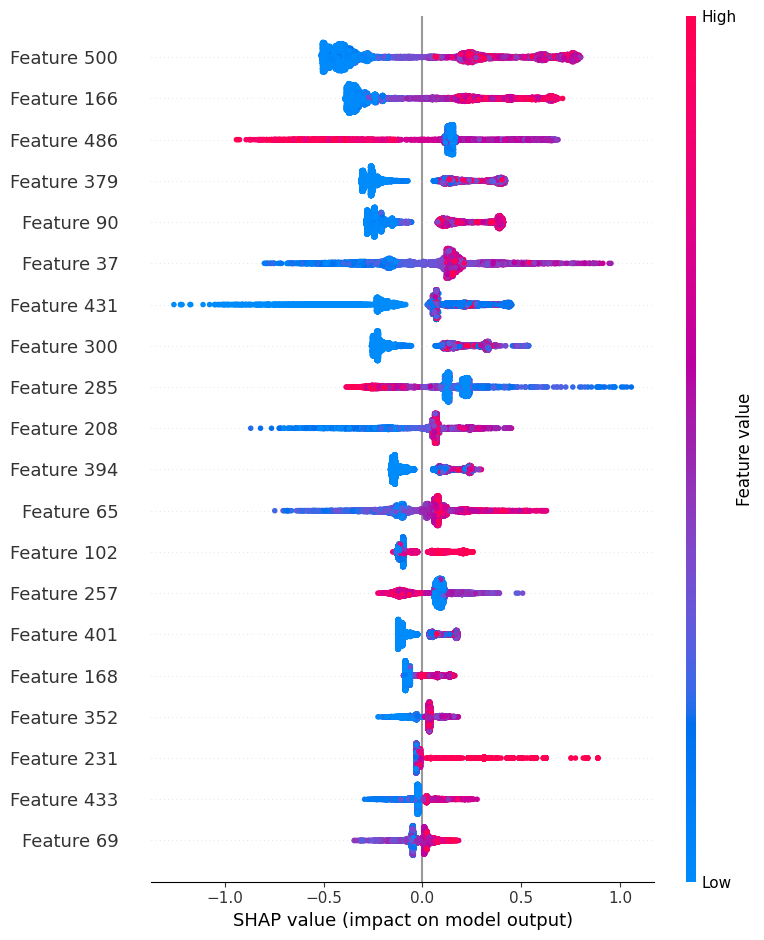

In [147]:
class_idx = 0
shap.summary_plot(shap_values[:, :, class_idx], X_train_unique)

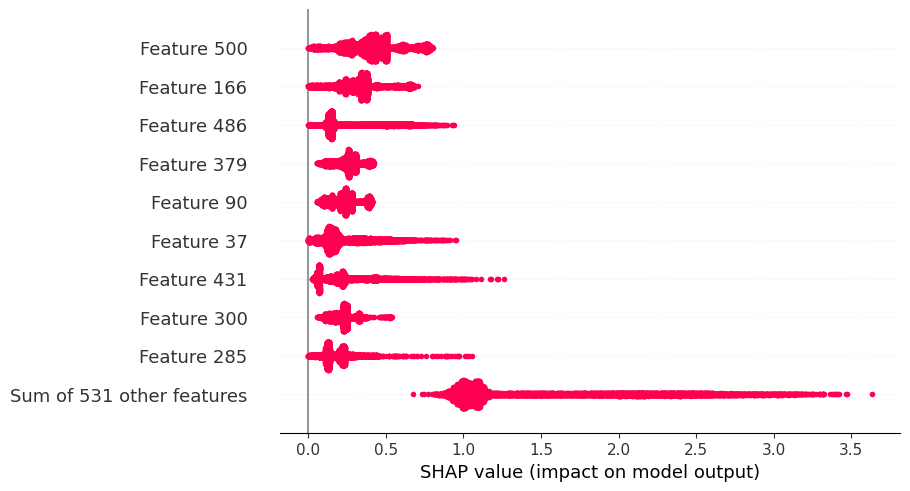

In [139]:
shap.plots.beeswarm(shap_values[:, :, 0].abs, color="shap_red")

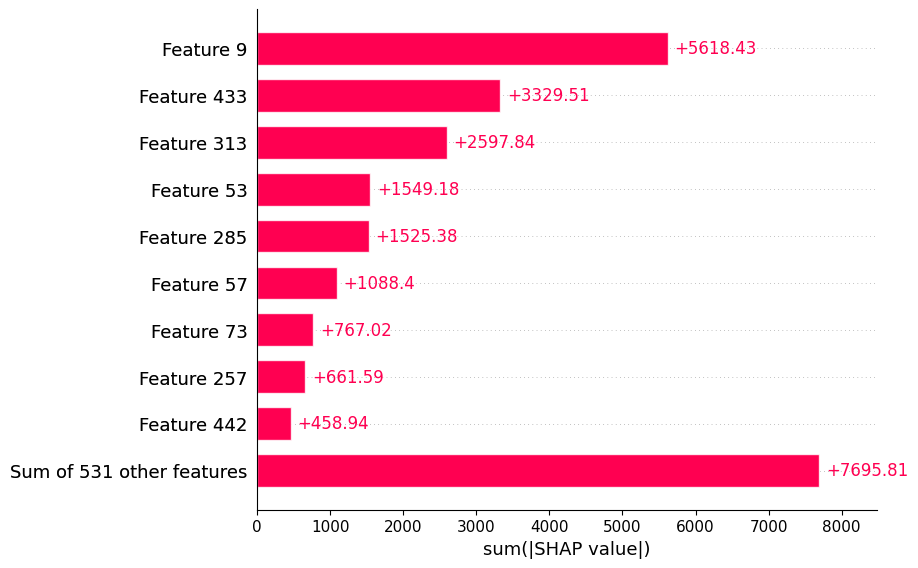

In [145]:
class_idx = 1
shap.plots.bar(shap_values[:, :, class_idx].abs.sum(0))

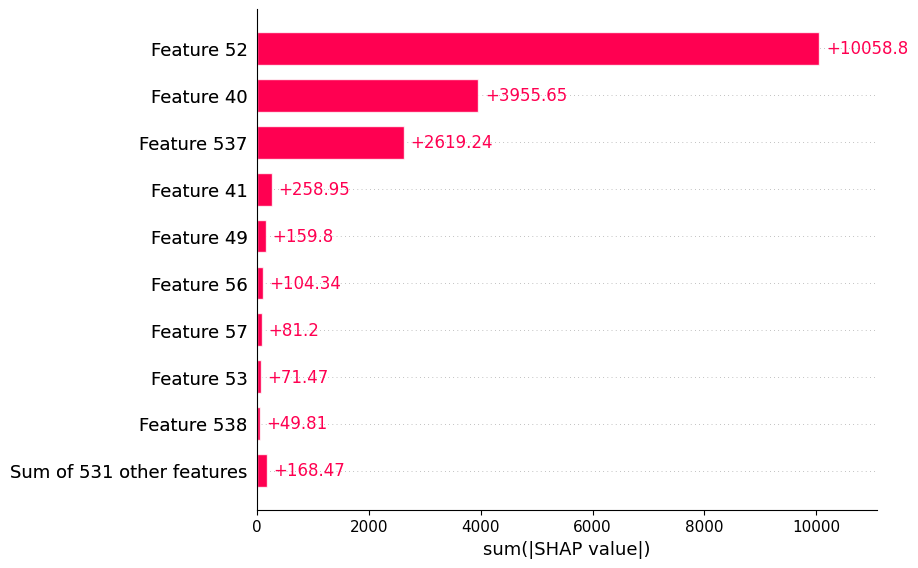

In [144]:
class_idx = 5
shap.plots.bar(shap_values[:, :, class_idx].abs.sum(0))

In [149]:
activity_labels # I subtracted 1 from each class label, remember that

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

### Conclusion

Your thoughts about the plots and model behaviour:

1) We can see by varying `class_idx` which features are the most important for identification of the corresponding class. E.g., for `class_idx`=5, we see that the decision can be made only by analysing 3 features => these 3 features can be viewed as distinctive features of some process (`LAYING` in that case)

2) We also can see from second graph which ranges of values are the most important for decision making (usually the highest/lowest and sometimes the values around mean of certain feature)

3) I guess, analysing more other plots in details, we also can understand how model make its decision in corner cases and controversal situations

I would dive deeper into analysis of `shap` values, but the features of this dataset (first one in that task) are not that *physically interpreted* to compare `model's` decision making with real life